In [5]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
from kalman import Kalman
from lss import LinearStateSpace
from scipy.stats import norm
from scipy.integrate import quad
from numpy.random import multivariate_normal
from scipy.linalg import eigvals

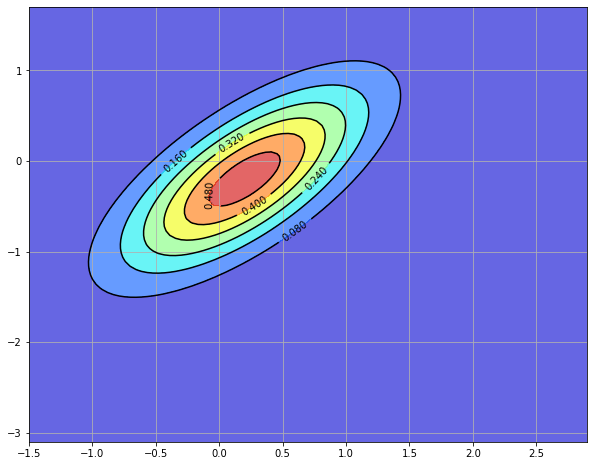

In [6]:
# Set up the Gaussian prior density p
Σ = [[0.4, 0.3], [0.3, 0.45]]
Σ = np.matrix(Σ)
x_hat = np.matrix([0.2, -0.2]).T
# Define the matrices G and R from the equation y = G x + N(0, R)
G = [[1, 0], [0, 1]]
G = np.matrix(G)
R = 0.5 * Σ
# The matrices A and Q
A = [[1.2, 0], [0, -0.2]]
A = np.matrix(A)
Q = 0.3 * Σ
# The observed value of y
y = np.matrix([2.3, -1.9]).T

# Set up grid for plotting
x_grid = np.linspace(-1.5, 2.9, 100)
y_grid = np.linspace(-3.1, 1.7, 100)
X, Y = np.meshgrid(x_grid, y_grid)

def bivariate_normal(x, y, σ_x=1.0, σ_y=1.0, μ_x=0.0, μ_y=0.0, σ_xy=0.0):
    """
    Compute and return the probability density function of bivariate normal
    distribution of normal random variables x and y

    Parameters
    ----------
    x : array_like(float)
        Random variable

    y : array_like(float)
        Random variable

    σ_x : array_like(float)
          Standard deviation of random variable x

    σ_y : array_like(float)
          Standard deviation of random variable y

    μ_x : scalar(float)
          Mean value of random variable x

    μ_y : scalar(float)
          Mean value of random variable y

    σ_xy : array_like(float)
           Covariance of random variables x and y

    """

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)
    return np.exp(-z / (2 * (1 - ρ**2))) / denom

def gen_gaussian_plot_vals(μ, C):
    "Z values for plotting the bivariate Gaussian N(μ, C)"
    m_x, m_y = float(μ[0]), float(μ[1])
    s_x, s_y = np.sqrt(C[0, 0]), np.sqrt(C[1, 1])
    s_xy = C[0, 1]
    return bivariate_normal(X, Y, s_x, s_y, m_x, m_y, s_xy)

# Plot the figure

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)

plt.show()

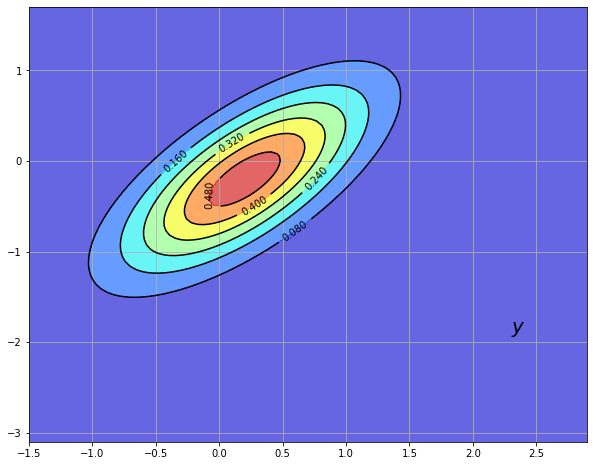

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
ax.contourf(X, Y, Z, 6, alpha=0.6, cmap=cm.jet)
cs = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

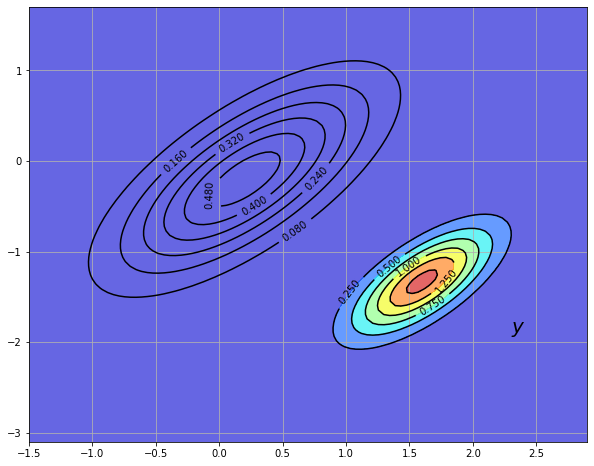

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
new_Z = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

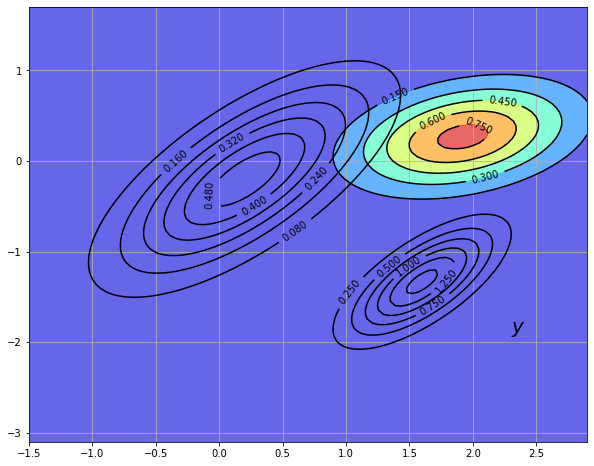

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Density 1
Z = gen_gaussian_plot_vals(x_hat, Σ)
cs1 = ax.contour(X, Y, Z, 6, colors="black")
ax.clabel(cs1, inline=1, fontsize=10)

# Density 2
M = Σ * G.T * linalg.inv(G * Σ * G.T + R)
x_hat_F = x_hat + M * (y - G * x_hat)
Σ_F = Σ - M * G * Σ
Z_F = gen_gaussian_plot_vals(x_hat_F, Σ_F)
cs2 = ax.contour(X, Y, Z_F, 6, colors="black")
ax.clabel(cs2, inline=1, fontsize=10)

# Density 3
new_x_hat = A * x_hat_F
new_Σ = A * Σ_F * A.T + Q
new_Z = gen_gaussian_plot_vals(new_x_hat, new_Σ)
cs3 = ax.contour(X, Y, new_Z, 6, colors="black")
ax.clabel(cs3, inline=1, fontsize=10)
ax.contourf(X, Y, new_Z, 6, alpha=0.6, cmap=cm.jet)
ax.text(float(y[0]), float(y[1]), "$y$", fontsize=20, color="black")

plt.show()

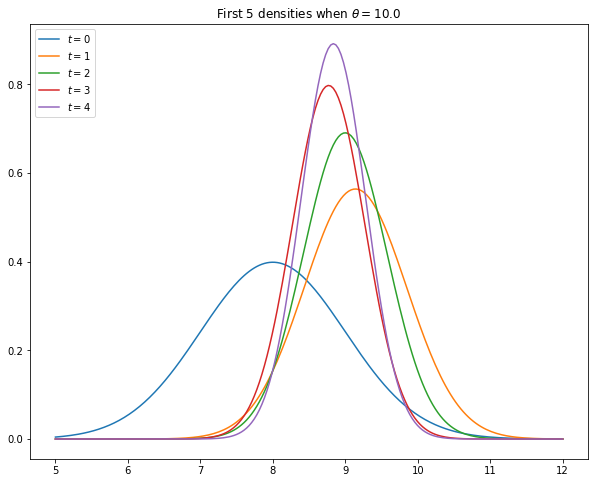

In [10]:
# Parameters
θ = 10  # Constant value of state x_t
A, C, G, H = 1, 0, 1, 1
ss = LinearStateSpace(A, C, G, H, mu_0=θ)

# Set prior, initialize kalman filter
x_hat_0, Σ_0 = 8, 1
kalman = Kalman(ss, x_hat_0, Σ_0)

# Draw observations of y from state space model
N = 5
x, y = ss.simulate(N)
y = y.flatten()

# Set up plot
fig, ax = plt.subplots(figsize=(10,8))
xgrid = np.linspace(θ - 5, θ + 2, 200)

for i in range(N):
    # Record the current predicted mean and variance
    m, v = [float(z) for z in (kalman.x_hat, kalman.Sigma)]
    # Plot, update filter
    ax.plot(xgrid, norm.pdf(xgrid, loc=m, scale=np.sqrt(v)), label=f'$t={i}$')
    kalman.update(y[i])

ax.set_title(f'First {N} densities when $\\theta = {θ:.1f}$')
ax.legend(loc='upper left')
plt.show()

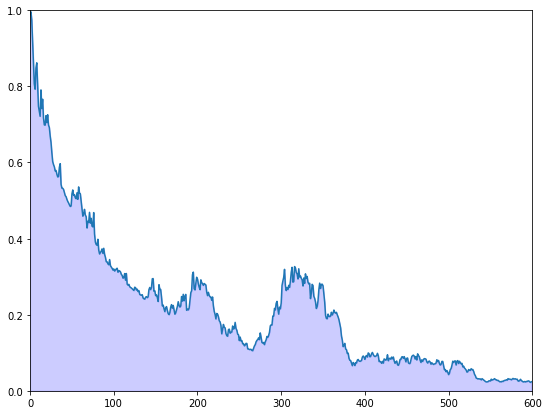

In [11]:
ϵ = 0.1
θ = 10  # Constant value of state x_t
A, C, G, H = 1, 0, 1, 1
ss = LinearStateSpace(A, C, G, H, mu_0=θ)

x_hat_0, Σ_0 = 8, 1
kalman = Kalman(ss, x_hat_0, Σ_0)

T = 600
z = np.empty(T)
x, y = ss.simulate(T)
y = y.flatten()

for t in range(T):
    # Record the current predicted mean and variance and plot their densities
    m, v = [float(temp) for temp in (kalman.x_hat, kalman.Sigma)]

    f = lambda x: norm.pdf(x, loc=m, scale=np.sqrt(v))
    integral, error = quad(f, θ - ϵ, θ + ϵ)
    z[t] = 1 - integral

    kalman.update(y[t])

fig, ax = plt.subplots(figsize=(9, 7))
ax.set_ylim(0, 1)
ax.set_xlim(0, T)
ax.plot(range(T), z)
ax.fill_between(range(T), np.zeros(T), z, color="blue", alpha=0.2)
plt.show()

Eigenvalues of A:
[ 0.9+0.j -0.1+0.j]
Stationary prediction error variance:
[[0.40329108 0.1050718 ]
 [0.1050718  0.41061709]]


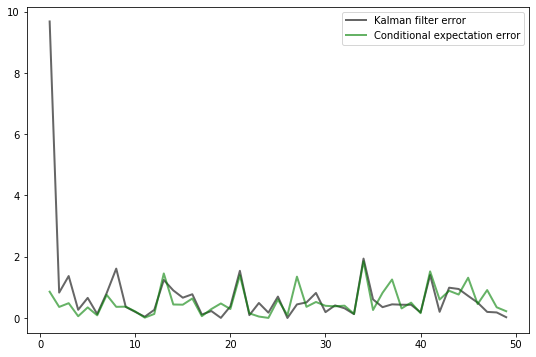

In [12]:
# Define A, C, G, H
G = np.identity(2)
H = np.sqrt(0.5) * np.identity(2)

A = [[0.5, 0.4],
     [0.6, 0.3]]
C = np.sqrt(0.3) * np.identity(2)

# Set up state space mode, initial value x_0 set to zero
ss = LinearStateSpace(A, C, G, H, mu_0 = np.zeros(2))

# Define the prior density
Σ = [[0.9, 0.3],
     [0.3, 0.9]]
Σ = np.array(Σ)
x_hat = np.array([8, 8])

# Initialize the Kalman filter
kn = Kalman(ss, x_hat, Σ)

# Print eigenvalues of A
print("Eigenvalues of A:")
print(eigvals(A))

# Print stationary Σ
S, K = kn.stationary_values()
print("Stationary prediction error variance:")
print(S)

# Generate the plot
T = 50
x, y = ss.simulate(T)

e1 = np.empty(T-1)
e2 = np.empty(T-1)

for t in range(1, T):
    kn.update(y[:,t])
    e1[t-1] = np.sum((x[:, t] - kn.x_hat.flatten())**2)
    e2[t-1] = np.sum((x[:, t] - A @ x[:, t-1])**2)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(1, T), e1, 'k-', lw=2, alpha=0.6,
        label='Kalman filter error')
ax.plot(range(1, T), e2, 'g-', lw=2, alpha=0.6,
        label='Conditional expectation error')
ax.legend()
plt.show()